In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
# Librerías para visualizacion
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import re
import networkx as nx
from itertools import count
from itertools import combinations
from itertools import product
import statsmodels.api as sm
import urllib.request, json
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
import seaborn as sns
sns.set_style('whitegrid') # grids en dark background

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('librerías cargadas')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
librerías cargadas


#¿Qué es PRODY?

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product.

Se importa la base desde drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## Se importa la base de exportaciones de productos drive
df = pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
print('dataframe cargado')

dataframe cargado


In [6]:
df.sample(n=6)
df.info()

,year,country_code,country_name,product_code,product_name,export_value
5483641,2007,KHM,Cambodia,8001,Tin; unwrought,0
3860121,2009,TUV,Tuvalu,5607,"Twine, cordage, ropes and cables, whether or not plaited or braided; whether or not impregnated, coated, covered or sheathed with rubber or plastics",2976
6266513,2008,IND,India,8502,Electric generating sets and rotary converters,729637440
2830975,2009,NZL,New Zealand,4007,Vulcanised rubber thread and cord,149136
1224600,2001,ISR,Israel,2506,"Quartz; (other than natural sands), quartzite, whether or not roughly trimmed or merely cut, by sawing or otherwise, into blocks or slabs of a rectangular (including square) shape",203879
5213779,2017,CXR,Christmas Island,7411,Copper tubes and pipes,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7373271 entries, 0 to 7373270
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   year          int64 
 1   country_code  object
 2   country_name  object
 3   product_code  int64 
 4   product_name  object
 5   export_value  int64 
dtypes: int64(3), object(3)
memory usage: 337.5+ MB


In [7]:
df['country_name'].nunique()

242

#Calculo de RCA

In [8]:
## Función para el cálculo de RCA

def calc_rca(data,pais_col,prod_col,anio_col,value_col):
    """
      La función que calcula la RCA
    
    """
    print('Creando las combinaciones de país-producto-tiempo')
    df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    df_all.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # En esta parte se calculan propiedades
    print('calculando')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA
    
    ## 0 si el producto / país tiene 0 exportaciones
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0 
    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all


In [9]:
df_rca = calc_rca(data=df,pais_col='country_name',prod_col='product_name',anio_col='year',value_col='export_value')

print('rca listo!!')

# Se muestran resultados
df_rca[0:10]

Creando las combinaciones de país-producto-tiempo
Se procede a fusionar los datos
calculando
rca listo!!


,year,country_name,product_name,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18008.00,0.13
1,1995,Aruba,Bovine animals; live,0.00,0.00
2,1995,Aruba,Swine; live,0.00,0.00
3,1995,Aruba,Sheep and goats; live,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2336.00,0.05
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",0.00,0.00


In [10]:
df_rca['country_name'].nunique()

242

###Se filtra el dataframe solo para Ecuador

In [11]:

# Ecuador
df_rca[ (df_rca['country_name']=='Ecuador')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:10]


,product_name,RCAcpt,year
2176048,"Bananas, including plantains; fresh or dried",266.11,2002
2476612,"Bananas, including plantains; fresh or dried",245.41,2003
1875484,"Bananas, including plantains; fresh or dried",244.05,2001
1574920,"Bananas, including plantains; fresh or dried",241.97,2000
1274356,"Bananas, including plantains; fresh or dried",234.63,1999
6384612,"Hat-shapes; plaited or made by assembling strips of any material, neither blocked to shape, nor with made brims, nor lined, nor trimmed",233.22,2016
6383944,"Bananas, including plantains; fresh or dried",231.67,2016
673228,"Bananas, including plantains; fresh or dried",229.02,1997
6684508,"Bananas, including plantains; fresh or dried",227.59,2017
6985072,"Bananas, including plantains; fresh or dried",225.52,2018


In [12]:
## Se importa la base de gdp percapita de todos los países desde el drive
df_gdppc_countries = pd.read_csv("/content/drive/MyDrive/eci/base/gpd_per_capita_countries_db.csv").copy()
print('dataframe del gpd cargado')

dataframe del gpd cargado


In [13]:
df_gdppc_countries[0:3]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6283.00,7567.25,9274.51,10767.40,11638.73,12850.22,13657.67,14970.15,16675.28,17140.43,17375.23,18713.43,19742.32,19833.83,21023.16,20913.30,21377.10,22050.83,24104.65,24975.67,25833.45,27665.43,29011.56,25739.14,24452.93,26044.44,25609.96,26515.68,26942.31,28421.39,28451.27,29326.71,30220.59,31650.76,24487.86,29342.10
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,162.91,162.55,172.00,199.18,179.38,198.22,209.41,211.70,224.23,249.58,260.11,278.75,293.08,370.41,444.72,459.90,444.08,489.85,530.37,600.37,738.87,732.92,681.65,691.99,615.41,508.69,552.54,654.32,697.22,722.43,817.15,858.30,728.77,704.74,697.18,762.84,739.47,757.85,696.37,669.69,706.99,628.20,626.56,812.95,985.53,1120.45,1226.18,1369.81,1428.33,1411.58,1643.55,1792.85,1760.22,1731.80,1719.81,1540.85,1432.11,1613.79,1550.18,1500.23,1353.77,1537.34
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,62.37,62.44,60.95,82.02,85.51,105.24,143.10,167.17,134.01,134.25,162.64,166.22,141.37,149.74,181.60,194.67,205.67,232.78,255.05,284.76,291.65,311.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.53,200.46,221.66,255.06,274.00,375.08,387.85,443.85,554.60,621.91,663.14,651.99,628.15,592.48,520.25,530.15,502.06,500.52,516.87,368.75


In [14]:
## Se modifica la base de gdp per capita con los datos que solo nos interesan
df_gdppc = df_gdppc_countries.filter(items=['Country Name','Country Code','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']).copy()
df_gdppc=df_gdppc.rename(columns={"Country Name": "country_name", "Country Code": "country_code"}).copy()
df_gdppc=df_gdppc.melt(id_vars=["country_name", "country_code"], 
        var_name="year", 
        value_name="Value").copy()
df_gdppc=df_gdppc.rename(columns={"Value": "gdp_per_capita"}).copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Latin America & the Caribbean (IDA & IBRD countries)' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Europe & Central Asia (excluding high income)' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'World' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Fragile and conflict affected situations'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Pacific island small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'OECD members'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Caribbean small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Heavily indebted poor countries (HIPC)'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'East Asia & Pacific (excluding high income)'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Europe & Central Asia (IDA & IBRD countries)'].copy()
df_gdppc =  df_gdppc.loc[(df_gdppc["country_name"] != 'Lower middle income') & (df_gdppc["country_name"] != 'IBRD only')& (df_gdppc["country_name"] != 'IDA total') & (df_gdppc["country_name"] != 'East Asia & Pacific')
&(df_gdppc['country_name']!='Sub-Saharan Africa (excluding high income)')&(df_gdppc['country_name']!='Low & middle income')&(df_gdppc['country_name']!='Not classified')
&(df_gdppc['country_name']!='Middle East & North Africa (IDA & IBRD countries)')&(df_gdppc['country_name']!='Post-demographic dividend')&(df_gdppc['country_name']!='Latin America & Caribbean')
&(df_gdppc['country_name']!='Middle income')&(df_gdppc['country_name']!='East Asia & Pacific (IDA & IBRD countries)')&(df_gdppc['country_name']!='IDA & IBRD total') &(df_gdppc['country_name']!='South Asia (IDA & IBRD)')
&(df_gdppc['country_name']!='South Asia')
&(df_gdppc['country_name']!='Least developed countries: UN classification')].copy()
## Se reemplaza actualiza los nombres de paises de la base del Banco Mundial para igualarlos con los de la base CONTRADE
df_gdppc=df_gdppc.replace("Korea, Dem. People's Rep.", "North Korea").copy()
df_gdppc=df_gdppc.replace("Korea, Rep.", "South Korea").copy()
df_gdppc=df_gdppc.replace("Cote d'Ivoire", "Côte d'Ivoire").copy()
df_gdppc=df_gdppc.replace("Congo, Dem. Rep.", "Congo (Democratic Republic of the)").copy()
df_gdppc=df_gdppc.replace("Congo, Rep.", "Congo").copy()
df_gdppc=df_gdppc.replace("Curacao", "Curaçao").copy()
df_gdppc=df_gdppc.replace("British Virgin Islands","Virgin Islands (British)").copy()
df_gdppc=df_gdppc.replace("Egypt, Arab Rep.","Egypt").copy()
df_gdppc=df_gdppc.replace("Hong Kong SAR","Hong Kong").copy()
df_gdppc=df_gdppc.replace("United States","United States of America").copy()
df_gdppc=df_gdppc.replace("St. Vincent and the Grenadines","Saint Vincent and the Grenadines").copy()
df_gdppc=df_gdppc.replace("Venezuela, RB","Venezuela").copy()







# df_gdppc = df_gdppc.drop(df_gdppc.index[3254]).copy()
# df_gdppc = df_gdppc.drop(df_gdppc.index[3522]).copy() #Europe & Central Asia (excluding high income)
# df_gdppc = df_gdppc.drop(df_gdppc.index[1162]).copy() #Heavily indebted poor countries (HIPC)	
# df_gdppc = df_gdppc.drop(df_gdppc.index[[3960,3965,134,4703,1579,5193,2092,2454,449,3407,1395,1204,191,4143,1394,3993,3096,1527,3254,3522,1162,3428,4132,4454]]).copy() #Heavily indebted poor countries (HIPC),	Latin America & the Caribbean (IDA & IBRD countries)	
df_gdppc["year"]=df_gdppc["year"].astype(np.int64).copy()



df_gdppc.sample(n=10)
df_gdppc.shape
df_gdppc.info()
#World
#Fragile and conflict affected situations
#East Asia & Pacific (excluding high income)
#Pacific island small states

,country_name,country_code,year,gdp_per_capita
1959,Honduras,HND,2007,1559.89
2631,Timor-Leste,TLS,2009,682.17
4073,Ghana,GHA,2015,1711.29
4677,Marshall Islands,MHL,2017,4507.62
1741,Latvia,LVA,2006,9723.45
2822,Montenegro,MNE,2010,6688.48
2745,Guinea,GIN,2010,667.28
374,Isle of Man,IMN,2001,21716.95
11,American Samoa,ASM,2000,NaN
4338,Georgia,GEO,2016,4062.17


(4780, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 0 to 5319
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    4780 non-null   object 
 1   country_code    4780 non-null   object 
 2   year            4780 non-null   int64  
 3   gdp_per_capita  4592 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.7+ KB


In [15]:
df_gdppc['country_name'].nunique()

239

#### Se hace un merge entre la base de gdp por países y el dataframe de RCA

In [16]:
# se hace un merge entre la base de gdp por países y el dataframe de RCA
df_merge = df_rca.merge(df_gdppc, how='inner', on=['year','country_name']).copy()

df_merge.sample(n=10)
df_merge.shape

df_merge.info()

,year,country_name,product_name,export_value,RCAcpt,country_code,gdp_per_capita
3857726,2016,Ecuador,"Fruit, dried, other than that of heading no. 0801 to 0806; mixtures of nuts or dried fruits of this chapter",1680922.00,0.67,ECU,6079.09
868054,2003,Pakistan,"Boats, floating structures, other (for eg rafts, tanks, coffer-dams, landing stages, buoys and beacons)",343354.00,0.25,PAK,549.87
4664448,2019,Panama,"Umbrellas; sun umbrellas (including walking stick umbrellas, garden umbrellas and similar umbrellas)",308261.00,0.41,PAN,15826.08
3892461,2016,India,"Human hair; unworked, whether or not washed or scoured; waste of human hair",63043928.00,28.76,IND,1714.28
4168508,2017,Northern Mariana Islands,"Glycosides, natural or reproduced by synthesis, and their salts, ethers, esters and other derivatives",0.00,0.00,MNP,30751.64
1476422,2006,Cayman Islands,"Tin; plates, sheets and strip, of a thickness exceeding 0.2mm",0.00,0.00,CYM,87187.65
846302,2003,Mongolia,"Articles of apparel and clothing accessories, of leather or of composition leather",88401.00,0.17,MNG,633.95
4627880,2019,Lithuania,Vinegar and substitutes for vinegar obtained from acetic acid,1425507.00,1.26,LTU,19595.14
4295131,2018,Belarus,Hypochlorites; commercial calcium hypochlorite; chlorites; hypobromites,453834.00,0.45,BLR,6360.06
2609460,2011,Aruba,Fish; frozen (excluding fish fillets and other fish meat of heading no. 0304),0.00,0.00,ABW,26044.44


(4744440, 7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744440 entries, 0 to 4744439
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   year            int64  
 1   country_name    object 
 2   product_name    object 
 3   export_value    float64
 4   RCAcpt          float64
 5   country_code    object 
 6   gdp_per_capita  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 289.6+ MB


In [17]:
df_merge['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [18]:
df_gdppc['country_name'].unique()
print('\n')

print('se divide acá...')
print('\n')

df_rca['country_name'].unique()

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Côte d'Ivoire", 'Cameroon',
       'Congo (Democratic Republic of the)', 'Congo', 'Colombia',
       'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Curaçao',
       'Cayman Islands', 'Cyprus', 'Czechia', 'Germany', 'Djibouti',
       'Dominica', 'Denmark', 'Dominican Republic', 'Algeria',
       'Early-d



se divide acá...




array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'Netherlands Antilles', 'United Arab Emirates', 'Argentina',
       'Armenia', 'French Southern and Antarctic Lands',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Central African Republic',
       'Canada', 'Cocos (Keeling) Islands', 'Switzerland', 'Chile',
       'China', "Côte d'Ivoire", 'Cameroon',
       'Congo (Democratic Republic of the)', 'Congo', 'Cook Islands',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba',
       'Christmas Island', 'Cayman Islands', 'Cyprus', 'Czech Republic',
       'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic',
       'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Western Saha

In [19]:
df_rca['country_name'].nunique()
print('\n')
# 'St-Martin / St Maarten' esto está unificado y en la base del banco mundial están separados. 
df_merge['country_name'].nunique()

242

191

####Se elabora un dataframe solo con la base de Ecuador

In [20]:
df_ec= df_merge[ (df_merge['country_name']=='Ecuador')].sort_values(by=['year','RCAcpt'],ascending=True)[['product_name','RCAcpt','export_value','year','gdp_per_capita']].copy()
df_ec.sample(n=10)


,product_name,RCAcpt,export_value,year,gdp_per_capita
2908832,Melons (including watermelons) and papaws (papayas); fresh,2.06,8304531.00,2012,5678.46
300191,"Copper; refined and copper alloys, unwrought",0.01,51999.00,2001,1904.81
2909178,"Photographic plates and film in the flat, sensitised, unexposed, of any material other than paper, paperboard or textiles; instant print film in the flat, sensitised, unexposed, whether or not in packs",0.01,63841.00,2012,5678.46
2435014,"Garments; knitted or crocheted, n.e.s. in chapter 61",0.04,205407.00,2010,4640.25
774393,Synthetic filament tow,0.00,0.00,2003,2438.34
1960743,Copper mattes; cement copper (precipitated copper),0.62,442257.00,2008,4260.43
2908903,"Margarine; edible mixtures or preparations of animal or vegetable fats or oils or of fractions of different fats or oils of this chapter, other than edible fats or oils of heading no. 1516",0.86,7116359.00,2012,5678.46
1011467,"Conveyor or transmission belts or belting, of vulcanised rubber",0.02,58522.00,2004,2703.57
300246,Tin; waste and scrap,0.00,0.00,2001,1904.81
4094879,"Animals, n.e.s. in chapter 01; live",0.28,363320.00,2017,6246.40


Se crea el objeto de valores de gpd per capita de los últimos 20 años

In [21]:
gdp_per_capita_ec = [{'year':2000, 'gdp_per_capita': '1445.3'}, 
                     {'year': 2001, 'gdp_per_capita': '1894.6'},
                     {'year': 2002, 'gdp_per_capita' : '2172.1' },
                      {'year': 2003, 'gdp_per_capita': '2425.9'},
                      {'year': 2004, 'gdp_per_capita': '2691.3'},
                     {'year': 2005, 'gdp_per_capita': '3002.1'},
                      {'year': 2006, 'gdp_per_capita': '3328.9'},
                        {'year': 2007, 'gdp_per_capita': '3567.8'},
                        {'year': 2008, 'gdp_per_capita': '4249'},
                         {'year': 2009, 'gdp_per_capita': '4231.6'},
                         {'year': 2010, 'gdp_per_capita': '4633.6'},
                         {'year': 2011, 'gdp_per_capita': '5200.6'},
                         {'year': 2012, 'gdp_per_capita': '5682'},
                         {'year': 2013, 'gdp_per_capita': '6056.3'},
                         {'year': 2014, 'gdp_per_capita': '6377.1'},
                         {'year': 2015, 'gdp_per_capita': '6124.5'},
                          {'year': 2016, 'gdp_per_capita': '6060.1'},
                          {'year': 2017, 'gdp_per_capita': '6213.5'},
                          {'year': 2018, 'gdp_per_capita': '6295.9'},
                          {'year': 2019, 'gdp_per_capita': '6222.5'},
                     ]

            
df_gdp_ec = pd.DataFrame(gdp_per_capita_ec)
# help(gdp_per_capita_ec)
df_gdp_ec[0:10]


,year,gdp_per_capita
0,2000,1445.3
1,2001,1894.6
2,2002,2172.1
3,2003,2425.9
4,2004,2691.3
5,2005,3002.1
6,2006,3328.9
7,2007,3567.8
8,2008,4249
9,2009,4231.6


According to *Hausmann Hwang & Rodrik’s (2005)*, the authors measure this sophistication indirectly by examining the wages of countries
who are intensive exporters of each product. First, they measure the sophistication of each
product, which they call PRODY, which is the revealed comparative advantage (RCA)-weighted
GDP per capita of each country that exports the good:



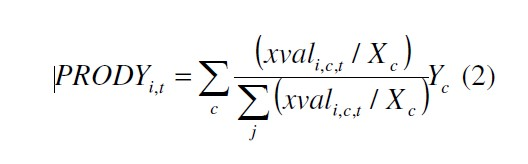

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product. As mentioned above, Hausmann Hwang & Rodrik use this product-level variable to calculate the level of sophistication of a country’s export basket, EXPYc,t as
the PRODYi,t for each component of the country’s export basket weighted by its share.

In [33]:
def calc_prody(data,pais_col,prod_col,anio_col,export_col, gdp_per_capita_col):
    
    """
      Función que calcula el valor de Prody
      Xc: equals total exports by country c, 
      Yc: equals GDP per capita of country c.

    """
    """
      Where xvali,c,t equals exports of good i by country c in year t

    """
    print('En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t')
    df_prody = pd.DataFrame(list(product(data[anio_col].unique(),data[pais_col].unique(),data[prod_col].unique())))
    df_prody.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_prody = pd.merge(df_prody,data[[anio_col,pais_col,prod_col,export_col,gdp_per_capita_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_prody.loc[df_prody[export_col].isnull(),export_col] = 0

    print('Se hace el calculo de RCA')

    df_prody['Xcpt'] = df_prody[export_col]
    df_prody['Xct'] = df_prody.groupby([pais_col, anio_col])[export_col].transform(sum)
    df_prody['Xpt'] = df_prody.groupby([prod_col, anio_col])[export_col].transform(sum)
    df_prody['Xt'] = df_prody.groupby([anio_col])[export_col].transform('sum')
    # df_prody['Yc'] = df_prody.groupby([pais_col, anio_col])[gdp_per_capita_col]
    df_prody['Yc'] = df_prody[gdp_per_capita_col]
    # yc_value = data.groupby(anio_col)[]
    # df_xval = data.groupby(export_col).transform('sum')
    df_prody['RCAcpt'] = (df_prody['Xcpt']/df_prody['Xct'])/(df_prody['Xpt']/df_prody['Xt']) #--> ecuación de las RCA
    df_prody.loc[df_prody['RCAcpt'].isnull(),'RCAcpt'] = 0

    print('Se hace el calculo de PRODY')

    df_prody['PRODY'] = ((df_prody['Xcpt']/df_prody['Xct'])/(df_prody['Xpt']/df_prody['Xt']))*df_prody['Yc'] 

    #retiro las propiedadades del dataframe 
    df_prody.drop(['Xcpt','Xct','Xpt','Xt','Yc'],axis=1,inplace=True,errors='ignore')


    return df_prody



In [23]:
    # print('Creando las combinaciones de país-producto-tiempo')
    # df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    # df_all.columns=[anio_col,pais_col,prod_col]
    # print('Se procede a fusionar los datos')
    # df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    # df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # # En esta parte se calculan propiedades
    # print('calculando')
    # df_all['Xcpt'] = df_all[value_col]
    # df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    # df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    # df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    # df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA

In [24]:
# !git --version
# !git config --global user.name "descandon88"
# !git config --global user.email "david.escandon.v@gmail.com"


In [34]:
df_prody = calc_prody(data=df_merge,pais_col='country_name',prod_col='product_name',anio_col='year',export_col='export_value',gdp_per_capita_col='gdp_per_capita').copy()
df_prody.sample(n=10)

En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t
Se procede a fusionar los datos
Se hace el calculo de RCEA
Se hace el calculo de PRODY


,year,country_name,product_name,export_value,gdp_per_capita,RCAcpt,PRODY
4574007,2019,Spain,"Bells, gongs and the like; non-electric, statuettes, other ornaments, photograph, picture, similar frames, mirrors, of base metal",28767564.00,29581.52,0.66,19604.64
426327,2001,Seychelles,Halogenated derivatives of hydrocarbons,0.00,7663.14,0.00,0.00
4102228,2017,Ethiopia,"Binoculars, monoculars, other optical telescopes, mountings therefor; other astronomical instruments, mountings therefor, but not including instruments for radio-astronomy",7904.00,755.75,0.04,28.97
2261120,2009,Madagascar,"Fabrics; knitted or crocheted, other than those of heading no. 6001",2148098.00,455.41,1.57,715.09
2955221,2012,Kazakhstan,"Articles of gut (other than silk-worm gut), of goldbeater's skin, of bladders or of tendons",0.00,12386.70,0.00,0.00
1450249,2006,Belize,"Alloy steel in ingots or other primary forms, semi-finished products of other alloy steel",0.00,5475.72,0.00,0.00
1084240,2004,Mongolia,"Roundabouts, swings, shooting galleries, other fairground amusements, travelling circuses, travelling menageries and travelling theatres",1707.00,784.91,0.03,23.58
2286632,2009,Nauru,Flours and meals of oil seeds or oleaginous fruits; other than those of mustard,0.00,NaN,0.00,NaN
3166169,2013,Guinea-Bissau,Radioactive chemical elements and radioactive isotopes (including the fissile or fertile chemical elements and isotopes); and their compounds; mixtures and residues containing these products,0.00,616.16,0.00,0.00
231151,2000,Namibia,"Margarine; edible mixtures or preparations of animal or vegetable fats or oils or of fractions of different fats or oils of this chapter, other than edible fats or oils of heading no. 1516",186479.00,2156.10,1.13,2429.42


In [32]:
df_prody[ (df_prody['country_name']=='Ecuador')].sort_values(by=['year'],ascending=True)[['product_name','export_value','year','gdp_per_capita','RCAcpt','PRODY']].copy()

,product_name,export_value,year,gdp_per_capita,RCAcpt,PRODY
62100,"Horses, asses, mules and hinnies; live",56778.00,2000,1451.53,0.03,50.12
62932,"Stainless steel bars and rods, hot-rolled, in irregularly wound coils",330106.00,2000,1451.53,0.42,613.76
62931,Stainless steel; flat-rolled products of width less than 600mm,0.00,2000,1451.53,0.00,0.00
62930,Stainless steel; flat-rolled products of width of 600mm or more,146909.00,2000,1451.53,0.01,21.62
62929,Stainless steel in ingots or other primary forms; semi-finished products of stainless steel,0.00,2000,1451.53,0.00,0.00
...,...,...,...,...,...,...
4569728,Safety fuses; detonating fuses; percussion or detonating caps; igniters; electric detonators,0.00,2019,6233.26,0.00,0.00
4569727,"Prepared explosives, other than propellent powders",0.00,2019,6233.26,0.00,0.00
4569726,Explosives; propellent powders,0.00,2019,6233.26,0.00,0.00
4569733,"Photographic film in rolls, sensitised, unexposed, of any material other than paper, paperboard or textiles; instant print film in rolls, sensitised, unexposed",0.00,2019,6233.26,0.00,0.00


##Cálculo de EXPY


This product-level measure of sophistication is then used to measure the sophistication of
a country’s export basket as a whole. The authors call this measure EXPY. EXPY is simply the
PRODY of each good (i) that country c exports, weighted by that good’s share in the country’s
export basket (Xc). It represents the income level associated with a country’s overall export
package.

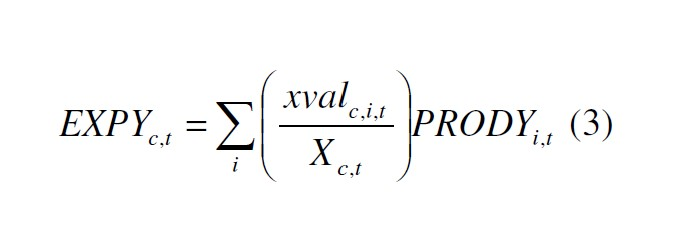

In [35]:
def calc_expy(data,pais_col,prod_col,anio_col,export_col, gdp_per_capita_col):
  """
  Función para el cálculo de EXPY c,t
  """
  print('En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t')
  df_expy = pd.DataFrame(list(product(data[anio_col].unique(),data[pais_col].unique(),data[prod_col].unique())))
  df_expy.columns=[anio_col,pais_col,prod_col]
  print('Se procede a fusionar los datos')